In [6]:
import numpy as np 
import pandas as pd 
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

# Website with football information that we will parse
url = 'https://understat.com/league'
# Defining all nidded info
leagues = ['La_liga', 'EPL', 'Bundesliga', 'Serie_A', 'Ligue_1', 'RFPL']
seasons = ['2014', '2015', '2016', '2017', '2018', '2019']

full_data = dict()

season_data = dict()
for season in seasons:    
    base_url = url+'/'+leagues[0]+'/'+season
    print(base_url)
    res = requests.get(base_url)
    soup = BeautifulSoup(res.content, "lxml")

    # To parse data we need JSON variable, under <script> tags
    scripts = soup.find_all('script')

    string_with_json_obj = ''

    # Here is data for teams
    for el in scripts:
        if 'teamsData' in el.text:
            string_with_json_obj = el.text.strip()

    # strip unnecessary symbols and get only JSON data
    ind_start = string_with_json_obj.index("('")+2
    ind_end = string_with_json_obj.index("')")
    json_data = string_with_json_obj[ind_start:ind_end]
    json_data = json_data.encode('utf8').decode('unicode_escape')


    # convert JSON data into Python dictionary
    data = json.loads(json_data)

    # Get teams and their relevant ids and put them into separate dictionary
    teams = {}
    for id in data.keys():
        teams[id] = data[id]['title']

    # EDA to get a feeling of how the JSON is structured
    # Column names are all the same, so we just use first element
    columns = []
    # Check the sample of values per each column
    values = []
    for id in data.keys():
        columns = list(data[id]['history'][0].keys())
        values = list(data[id]['history'][0].values())
        break

    # Getting data for all teams
    dataframes = {}
    for id, team in teams.items():
        teams_data = []
        for row in data[id]['history']:
            teams_data.append(list(row.values()))

        df = pd.DataFrame(teams_data, columns=columns)
        dataframes[team] = df
        print('Added data for {}.'.format(team))


    for team, df in dataframes.items():
        dataframes[team]['ppda_coef'] = dataframes[team]['ppda'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
        dataframes[team]['oppda_coef'] = dataframes[team]['ppda_allowed'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)

    cols_to_sum = ['xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored', 'missed', 'xpts', 'wins', 'draws', 'loses', 'pts', 'npxGD']
    cols_to_mean = ['ppda_coef', 'oppda_coef']

    frames = []
    for team, df in dataframes.items():
        sum_data = pd.DataFrame(df[cols_to_sum].sum()).transpose()
        mean_data = pd.DataFrame(df[cols_to_mean].mean()).transpose()
        final_df = sum_data.join(mean_data)
        final_df['team'] = team
        final_df['matches'] = len(df)
        frames.append(final_df)

    full_stat = pd.concat(frames)

    full_stat = full_stat[['team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'npxG', 'xGA', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 'xpts']]
    full_stat.sort_values('pts', ascending=False, inplace=True)
    full_stat.reset_index(inplace=True, drop=True)
    full_stat['position'] = range(1,len(full_stat)+1)

    full_stat['xG_diff'] = full_stat['xG'] - full_stat['scored']
    full_stat['xGA_diff'] = full_stat['xGA'] - full_stat['missed']
    full_stat['xpts_diff'] = full_stat['xpts'] - full_stat['pts']

    cols_to_int = ['wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'deep', 'deep_allowed']
    full_stat[cols_to_int] = full_stat[cols_to_int].astype(int)

    col_order = ['position', 'team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'xG_diff', 'npxG', 'xGA', 'xGA_diff', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 'xpts', 'xpts_diff']
    full_stat = full_stat[col_order]
    full_stat = full_stat.set_index('position')
    # print(full_stat.head(20))

    season_data[season] = full_stat

    df_season = pd.concat(season_data)
full_data[leagues[0]] = df_season

data = pd.concat(full_data)
data.to_csv('path yo your file')

https://understat.com/league/La_liga/2014
Added data for Malaga.
Added data for Sevilla.
Added data for Deportivo La Coruna.
Added data for Real Sociedad.
Added data for Espanyol.
Added data for Getafe.
Added data for Atletico Madrid.
Added data for Rayo Vallecano.
Added data for Valencia.
Added data for Athletic Club.
Added data for Barcelona.
Added data for Real Madrid.
Added data for Levante.
Added data for Celta Vigo.
Added data for Villarreal.
Added data for Granada.
Added data for Eibar.
Added data for Cordoba.
Added data for Elche.
Added data for Almeria.
https://understat.com/league/La_liga/2015
Added data for Malaga.
Added data for Sevilla.
Added data for Deportivo La Coruna.
Added data for Real Sociedad.
Added data for Espanyol.
Added data for Getafe.
Added data for Atletico Madrid.
Added data for Las Palmas.
Added data for Rayo Vallecano.
Added data for Valencia.
Added data for Athletic Club.
Added data for Barcelona.
Added data for Sporting Gijon.
Added data for Real Madrid

In [2]:
#Working with our DataFrame
df = data
df.all()

Unnamed: 0       True
Unnamed: 1       True
position         True
team             True
matches          True
wins             True
draws           False
loses           False
scored           True
missed           True
pts              True
xG               True
xG_diff          True
npxG             True
xGA              True
xGA_diff         True
npxGA            True
npxGD            True
ppda_coef        True
oppda_coef       True
deep             True
deep_allowed     True
xpts             True
xpts_diff        True
dtype: bool

In [3]:
df = df.rename({'Unnamed: 0' : 'League'},axis = 'columns')
df = df.rename({'Unnamed: 1' : 'Year'}, axis = 1)
df.head()

,League,Year,position,team,matches,wins,draws,loses,scored,missed,...,xGA,xGA_diff,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff
0,La_liga,2014,1,Barcelona,38,30,4,4,110,21,...,28.444293,7.444293,24.727907,73.049305,5.683535,16.367593,489,114,94.0813,0.0813
1,La_liga,2014,2,Real Madrid,38,30,2,6,118,38,...,42.607198,4.607198,38.890805,47.213090,10.209085,12.929510,351,153,81.7489,-10.2511
2,La_liga,2014,3,Atletico Madrid,38,23,9,6,67,29,...,29.069107,0.069107,26.839271,25.748737,8.982028,9.237091,197,123,73.1353,-4.8647
3,La_liga,2014,4,Valencia,38,22,11,5,70,32,...,39.392572,7.392572,33.446477,16.257501,8.709827,7.870225,203,172,63.7068,-13.2932
4,La_liga,2014,5,Sevilla,38,23,7,8,71,45,...,47.862742,2.862742,41.916529,20.178070,8.276148,9.477805,305,168,67.3867,-8.6133


In [38]:
# I don't use 2019 year, because it's nor finished yet
all_teams = df[(df.Year != 2019)][['Year','League','team','wins','draws','loses','scored','missed','pts']]
all_teams.all()

Year      True
League    True
team      True
wins      True
draws     True
loses     True
scored    True
missed    True
pts       True
dtype: bool

In [39]:
# Who scored more goals 
most_scored = all_teams[['team','scored']].groupby('team').sum().sort_values('scored', ascending = False).reset_index()
most_scored

,team,scored
0,Barcelona,527
1,Real Madrid,491
2,Paris Saint Germain,481
3,Manchester City,435
4,Bayern Munich,429
...,...,...
155,FC Yenisey Krasnoyarsk,24
156,Tosno,23
157,Cordoba,22
158,Tom Tomsk,17


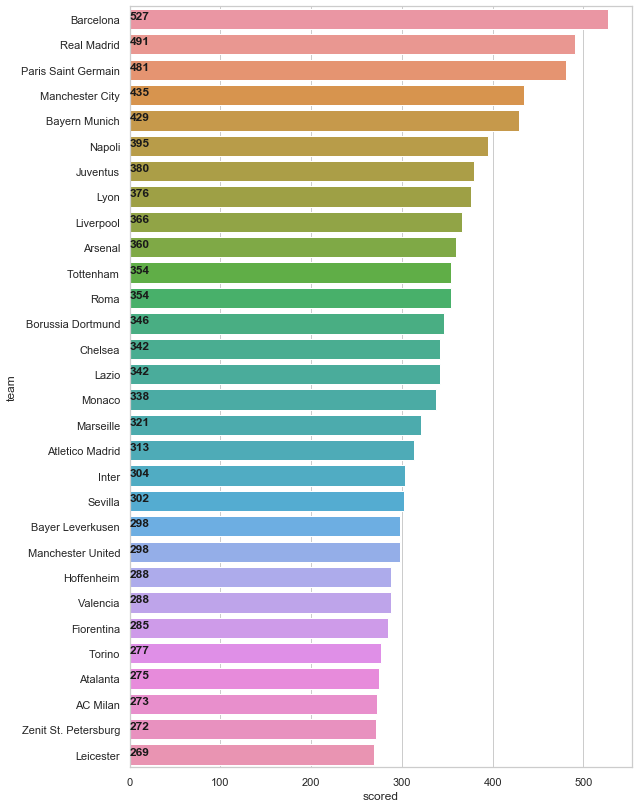

In [33]:
# TOP 30 teams by scored goals from 2014 - 2018
plt.figure(figsize=(9,14))
ax = sns.barplot(x = 'scored', y = 'team', data = most_scored[:30])
for i,j in enumerate(most_scored["scored"][:30]):
    ax.text(.3,i,j,weight="bold",color = "k",fontsize =12)

In [270]:
#Working with data from each league to plot it
La_liga = pd.DataFrame( df[(df.League  == 'La_liga') & (df.Year != 2019)][['Year','scored']]).groupby('Year',as_index = False).sum()
EPL = pd.DataFrame(df[(df.League  == 'EPL') & (df.Year != 2019)][['Year','scored']]).groupby('Year',as_index = False).sum()
Bundesliga = pd.DataFrame(df[(df.League  == 'Bundesliga') & (df.Year != 2019)][['Year','scored']]).groupby('Year',as_index = False).sum()
Serie_A = pd.DataFrame(df[(df.League  == 'Serie_A') & (df.Year != 2019)][['Year','scored']]).groupby('Year',as_index = False).sum()
Ligue_1 = pd.DataFrame(df[(df.League  == 'Ligue_1') & (df.Year != 2019)][['Year','scored']]).groupby('Year',as_index = False).sum()
RFPL = pd.DataFrame(df[(df.League  == 'RFPL') & (df.Year != 2019)][['Year','scored']]).groupby('Year',as_index = False).sum()

Text(0.5, 1.0, 'Serie_A')

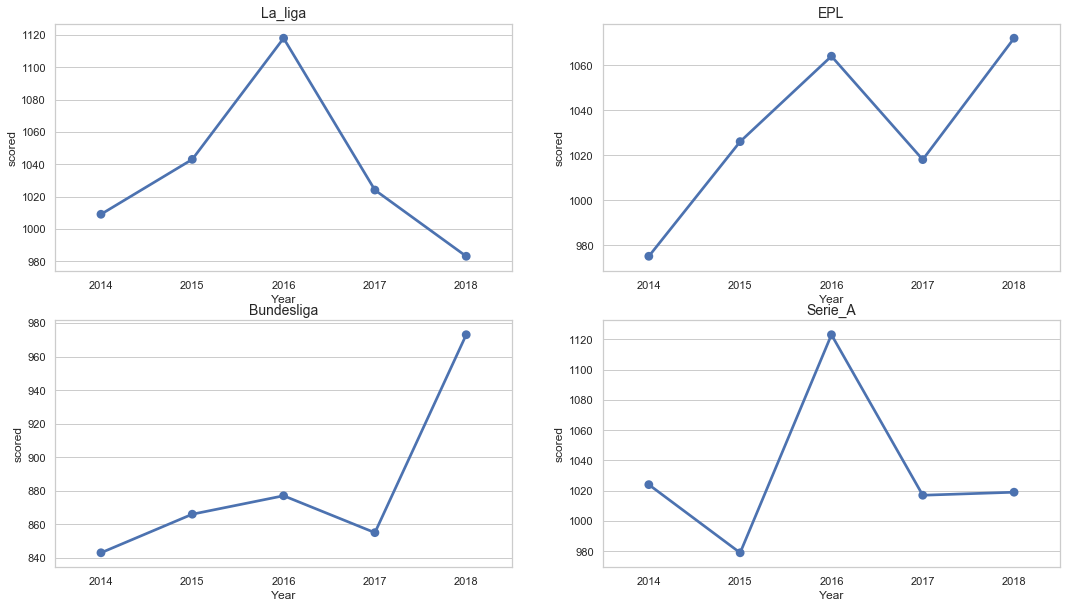

In [384]:
f, axes = plt.subplots(2, 2, figsize=(18,10))

g1 = sns.pointplot(x = 'Year', y = 'scored', kind = 'point',data=La_liga, ax=axes[0, 0])
g1.set_title('La_liga',fontsize=14)
g2 = sns.pointplot(x = 'Year', y = 'scored',kind='point',data=EPL, ax=axes[0, 1])
g2.set_title('EPL',fontsize=14)
g3 = sns.pointplot(x = 'Year', y = 'scored',kind='point',data=Bundesliga,ax=axes[1, 0])
g3.set_title('Bundesliga',fontsize=14)
g4 = sns.pointplot(x = 'Year', y = 'scored',kind='point',data=Serie_A, ax=axes[1, 1])
g4.set_title('Serie_A',fontsize=14)

In [6]:
leagues = all_teams['League'].unique()
leagues

array(['La_liga', 'EPL', 'Bundesliga', 'Serie_A', 'Ligue_1', 'RFPL'],
      dtype=object)

In [9]:
# Create DataFrames for each league to show how many goals every team had scored from 2014-2018
df_La_liga = pd.DataFrame( df[(df.League  == 'La_liga') & (df.Year != 2019)][['team','scored']]).groupby('team',as_index = False).sum().sort_values('scored', ascending = False)
df_EPL = pd.DataFrame(df[(df.League  == 'EPL') & (df.Year != 2019)][['team','scored']]).groupby('team',as_index = False).sum().sort_values('scored', ascending = False)
df_Bundesliga = pd.DataFrame(df[(df.League  == 'Bundesliga') & (df.Year != 2019)][['team','scored']]).groupby('team',as_index = False).sum().sort_values('scored', ascending = False)
df_Serie_A = pd.DataFrame(df[(df.League  == 'Serie_A') & (df.Year != 2019)][['team','scored']]).groupby('team',as_index = False).sum().sort_values('scored', ascending = False)
df_Ligue_1 = pd.DataFrame(df[(df.League  == 'Ligue_1') & (df.Year != 2019)][['team','scored']]).groupby('team',as_index = False).sum().sort_values('scored', ascending = False)
df_RFPL = pd.DataFrame(df[(df.League  == 'RFPL') & (df.Year != 2019)][['team','scored']]).groupby('team',as_index = False).sum().sort_values('scored', ascending = False)

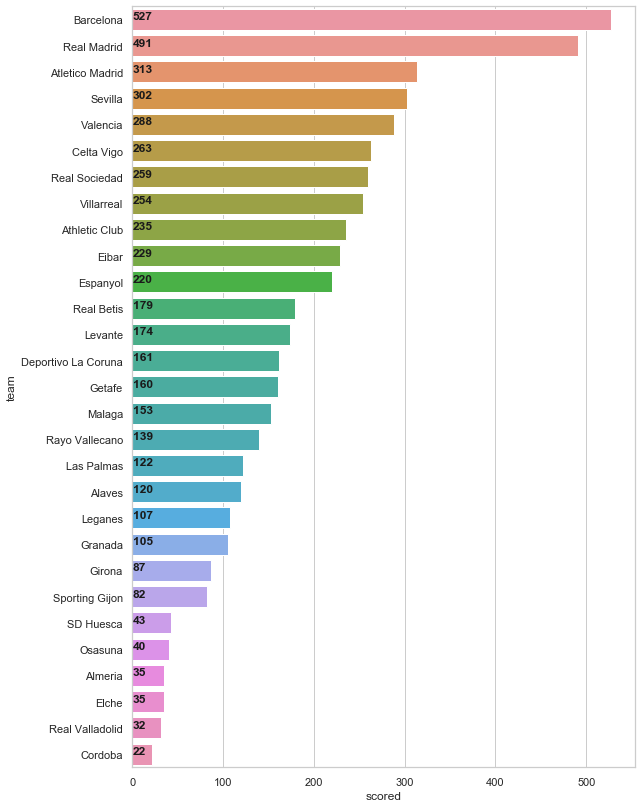

In [34]:
plt.figure(figsize=(9,14))
ax = sns.barplot(x = 'scored', y = 'team', data = df_La_liga)
for i,j in enumerate(df_La_liga["scored"]):
    ax.text(.3,i,j,weight="bold",color = "k",fontsize =12)

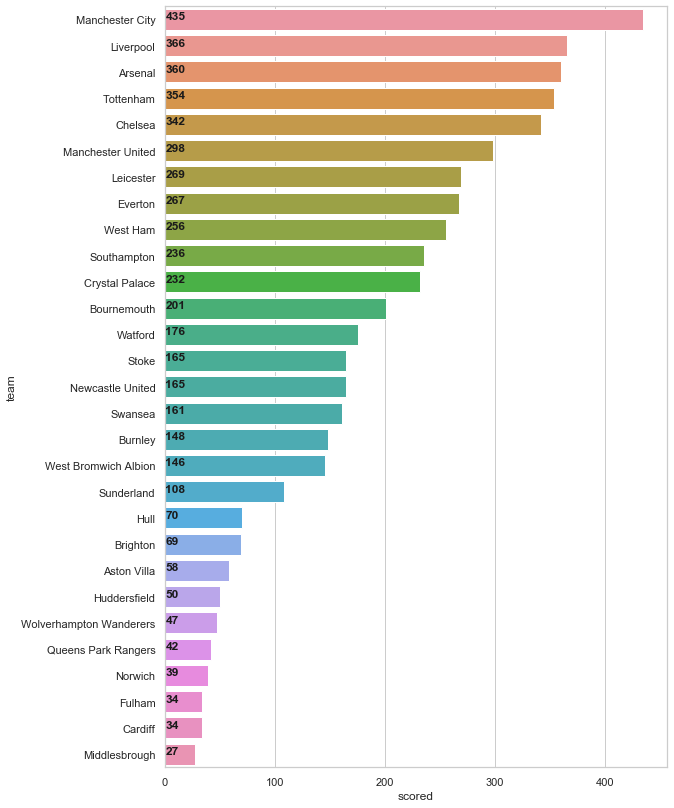

In [35]:
plt.figure(figsize=(9,14))
ax = sns.barplot(x = 'scored', y = 'team', data = df_EPL)
for i,j in enumerate(df_EPL["scored"]):
    ax.text(.3,i,j,weight="bold",color = "k",fontsize =12)

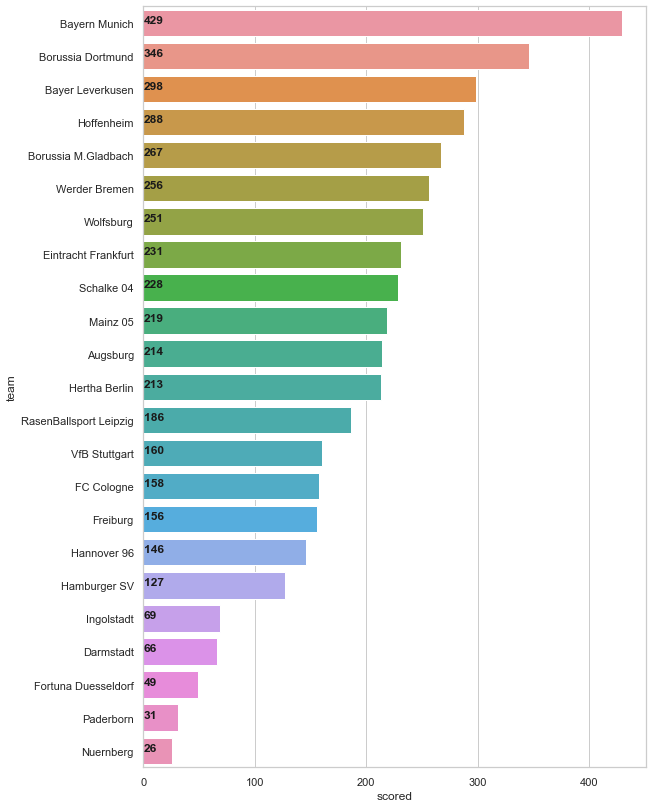

In [36]:
plt.figure(figsize=(9,14))
ax = sns.barplot(x = 'scored', y = 'team', data = df_Bundesliga)
for i,j in enumerate(df_Bundesliga["scored"]):
    ax.text(.3,i,j,weight="bold",color = "k",fontsize =12)

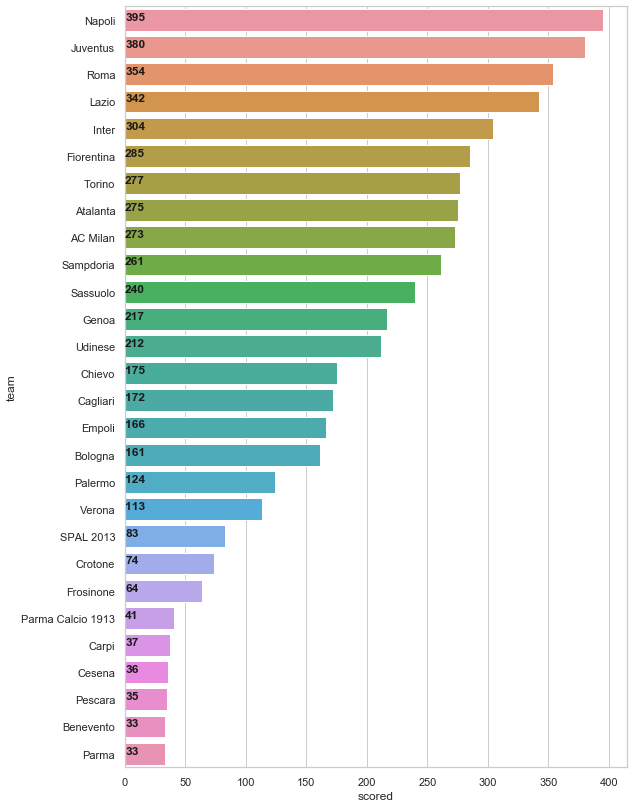

In [37]:
plt.figure(figsize=(9,14))
ax = sns.barplot(x = 'scored', y = 'team', data = df_Serie_A)
for i,j in enumerate(df_Serie_A["scored"]):
    ax.text(.3,i,j,weight="bold",color = "k",fontsize =12)

In [98]:
# Defining teams with most wins and most loses from 2014-2018
most_wins = all_teams[['team','wins']].groupby('team').sum().sort_values('wins', ascending = False).reset_index()
most_loses = all_teams[['team','loses']].groupby('team').sum().sort_values('loses', ascending = False).reset_index()

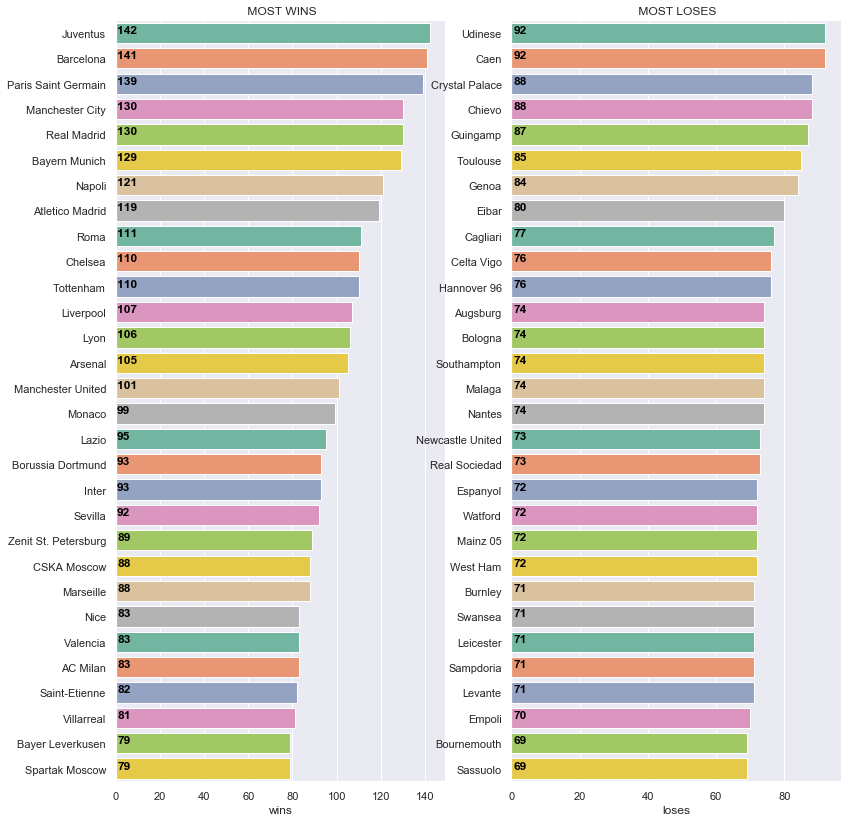

In [116]:
plt.figure(figsize=(13,14))
plt.subplot(121)

ax = sns.barplot(most_wins['wins'][:30],most_wins["team"][:30], palette="Set2",linewidth = 1)
plt.title(" MOST WINS")
plt.ylabel("")

for  i,j in enumerate(most_wins['wins'][:30]):
    ax.text(.7,i,j,color = 'black',weight = 'bold')
    
plt.subplot(122)
ax = sns.barplot(most_loses['loses'], most_loses['team'][:30], palette = 'Set2', linewidth = 1)
plt.title(' MOST LOSES')
plt.ylabel("")
for i,j in enumerate(most_loses['loses'][:30]):
    ax.text(.7,i,j,color = 'black', weight = 'bold')


In [164]:
# Showing who has more league titles
first_place = df[(df.position == 1) & (df.Year != 2019)][['Year','League','team','wins','draws','loses','scored','missed','pts']]
print(first_place['League'].unique())
first_place.head()

['La_liga' 'EPL' 'Bundesliga' 'Serie_A' 'Ligue_1' 'RFPL']


,Year,League,team,wins,draws,loses,scored,missed,pts
0,2014,La_liga,Barcelona,30,4,4,110,21,94
20,2015,La_liga,Barcelona,29,4,5,112,29,91
40,2016,La_liga,Real Madrid,29,6,3,106,41,93
60,2017,La_liga,Barcelona,28,9,1,99,29,93
80,2018,La_liga,Barcelona,26,9,3,90,36,87


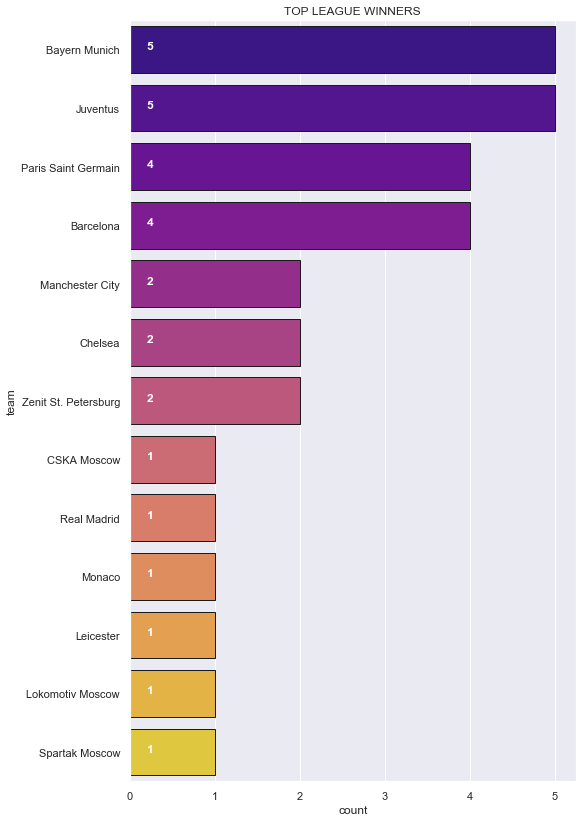

In [191]:
plt.figure(figsize=(8,14))
ax = sns.countplot(y=first_place["team"],order=first_place["team"].value_counts().index,
                   palette="plasma",linewidth = 1 ,edgecolor = "k"*first_place["team"].nunique())
plt.title("TOP LEAGUE WINNERS")
for i,j in enumerate(first_place["team"].value_counts().values):
    ax.text(.2,i,j,color = "white",weight="bold")

In [15]:
# Showing connection between all leagues stats('wins','draws','loses','scored','missed','pts')
first_pl_sorted = first_place.groupby(['League']).sum().sort_values('scored', ascending = False)
first_pl_sorted.head()

,wins,draws,loses,scored,missed,pts
League,,,,,,
La_liga,142,32,16,517,156,458
Ligue_1,142,32,16,505,150,458
Bundesliga,129,24,17,429,117,411
EPL,143,30,17,427,151,459
Serie_A,142,28,20,380,125,454


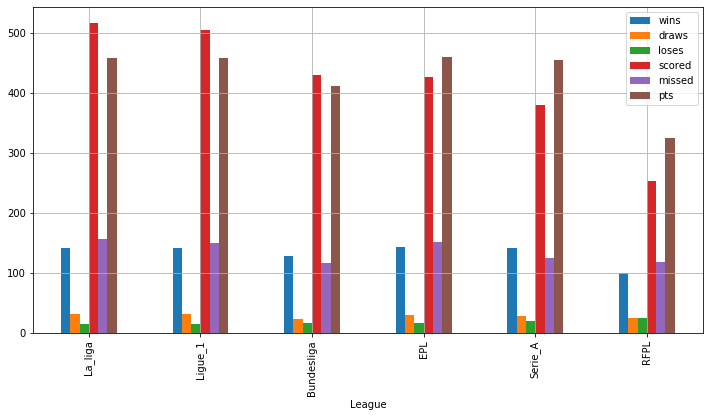

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
first_pl_sorted.plot.bar(ax = ax,grid = True)


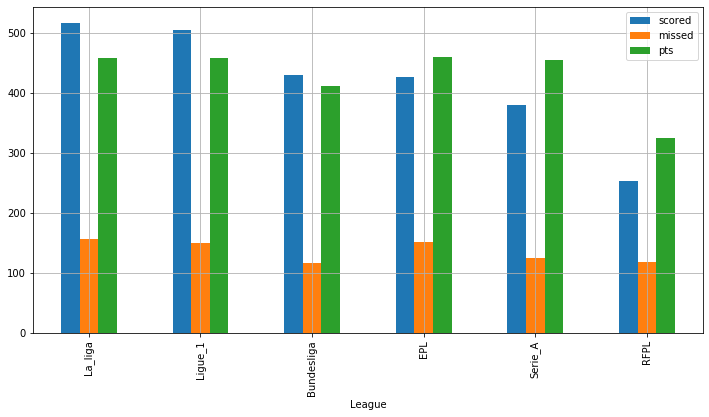

In [17]:
# Showing connection between scored/missed goals and points for every league from 2014 to 2018
pts_scored = first_pl_sorted[['scored','missed','pts']].sort_values('scored', ascending = False)
fig, ax = plt.subplots(figsize=(12,6))
pts_scored.plot.bar(ax = ax,grid = True)
